# Project 7 / Airport Delays + Cluster Analysis

### Description

You've been hired by the FAA as a consultant to analyze the operations of major airports around the country. The FAA wants to cut down on delays nationwide, and the most important part of this task is understanding the characteristics and groupings of airports based on a dataset of departure and operational delays.

A certain degree of delay is expected in airport operations, however the FAA is noticing significant delays with certain airports
When a flight takes off, it's departure delay is recorded in minutes, as well as operational data relating to this delay
At the end of the year, this data is averaged out for each airport. Your datasets have these averaged for a 10 year range between 2004 and 2014
Over this 10 year range, some delay times have not improved or have worsened.
Point: Your task is to understand the distribution, characteristics, and components of individual airports operations that are leading to these delays.

### Problem Statement

In this project, we're going to be using three different datasets related to airport operations. These include a dataset detailing the arrival and departure delays/diversions by airport, a dataset that provides metrics related to arrivals and departures for each airport, and a dataset that details names and characteristics for each airport code.

You will help the FAA:

Organize and store their data so that they can easily understand it after your consulting work is done
Mine and refine the data to uncover its basic attributes and characteristics
Use your skills with PCA to uncover the core components of operations related to delays.
When you've finished your analysis, the FAA would like a report detailing your findings, with recommendations as to which airports and operational characteristics they should target to decrease delays.

Here are some questions to keep in mind:

What operational factors are most directly correlated to delays?
Take a look at airports groupings - are there any relationships by region? Size?

### Requirements

Complete all of the tasks below:
- Write a problem statement & describe the goals of your study to be included in the final report
- Create a database to store your data; the FAA has dictated that you use PostgreSQL
- Conduct Exploratory Data Analysis to understand the attributes of our data; include your EDA findings in your final report to the FAA
- Mine & refine your data
- Conduct a PCA to discover the principal components behind departure delays
- Present the results of your findings in a formal report to the FAA, including the problem statement, summary statistics of the takeoff delays and operational delays, your PCA analysis detailing the principal components related to relays, and a case study on one specific airport that best illustrates your findings to FAA officials.
- Plot your PCA analysis on a 3-dimensional graph

### Step 1: Load Packages and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from lib.get_pca import feature_importance
from lib.cluster import kmeans, find_best_cluster

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
cancel_loc = "data/airport_cancellations.csv"
ops_loc = "data/Airport_operations.csv"
airports_loc = "data/airports.csv"

cancel = pd.read_csv(cancel_loc)
ops = pd.read_csv(ops_loc)
airports = pd.read_csv(airports_loc)

#### Airport Cancellations

In [3]:
cancel.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [4]:
cancel.shape

(805, 6)

#### Airport Operations

In [5]:
ops.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [6]:
ops.columns

Index([u'airport', u'year', u'departures for metric computation',
       u'arrivals for metric computation', u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay'],
      dtype='object')

In [7]:
ops.rename(columns={'airport':'LocID',
                    'average_gate_departure_delay': 'avg gate departure delay',
                    'average_taxi_out_time': 'avg taxi out time',
                    'average taxi out delay': 'avg taxi out delay',
                    'average airport departure delay': 'avg departure delay',
                    'average airborne delay': 'avg airborne delay',
                    'average taxi in delay': 'avg taxi in delay',
                    'average block delay': 'avg block delay',
                    'average gate arrival delay': 'avg gate arrival delay'}, inplace=True)

In [8]:
ops.shape

(841, 15)

#### Airport Delays

In [9]:
mask = ['avg gate departure delay',
        'avg taxi out delay',
        'avg departure delay',
        'avg airborne delay',
        'avg taxi in delay', 
        'avg block delay',
        'avg gate arrival delay']

In [10]:
delays = ops[mask]
delays.head()

,avg gate departure delay,avg taxi out delay,avg departure delay,avg airborne delay,avg taxi in delay,avg block delay,avg gate arrival delay
0,10.38,2.43,12.10,2.46,0.83,2.55,10.87
1,9.60,2.29,11.20,2.26,0.89,2.34,10.24
2,10.84,2.16,12.33,2.12,0.84,2.66,11.82
3,11.29,2.40,12.95,2.19,1.29,3.06,12.71
4,10.79,2.41,12.32,1.82,1.03,2.79,11.48


In [11]:
delays.shape

(841, 7)

#### Airports

In [12]:
airports.head()

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes


In [13]:
airports = airports.drop('ALIAS', axis=1)
airports = airports.dropna()

In [14]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5152 entries, 0 to 5163
Data columns (total 12 columns):
Key                        5152 non-null float64
LocID                      5152 non-null object
AP_NAME                    5152 non-null object
Facility Type              5152 non-null object
FAA REGION                 5152 non-null object
COUNTY                     5152 non-null object
CITY                       5152 non-null object
STATE                      5152 non-null object
AP Type                    5152 non-null object
Latitude                   5152 non-null float64
Longitude                  5152 non-null float64
Boundary Data Available    5152 non-null object
dtypes: float64(3), object(9)
memory usage: 523.2+ KB


In [15]:
airports.rename(columns={'Key':'key',
                         'LocID': 'LocID',
                         'AP_NAME': 'airport name',
                         'Facility Type': 'facility type',
                         'FAA REGION': 'FAA region',
                         'COUNTY': 'county',
                         'CITY': 'city',
                         'STATE': 'state',
                         'AP Type': 'airport type',
                         'Latitude': 'latitude',
                         'Longitude': 'longiutde'}, inplace=True)

### Step 2: Exploratory Data Analysis

#### Airport Cancellations

In [16]:
# Create percentages columns
cancel['total cancellations'] = cancel['Departure Cancellations'] + cancel['Arrival Cancellations']
cancel['total diversions'] = cancel['Departure Diversions'] + cancel['Arrival Diversions']
cancel['percentage of departure cancellations'] = 1.0 * cancel['Departure Cancellations'] / cancel['total cancellations']
cancel['percentage of arrival cancellations'] = 1.0 * cancel['Arrival Cancellations'] / cancel['total cancellations']
cancel['percentage of departure diversions'] = 1.0 * cancel['Departure Diversions'] / cancel['total diversions']
cancel['percentage of arrival diversions'] = 1.0 * cancel['Arrival Diversions'] / cancel['total diversions']

# Keep only percentages columns
cancel = cancel.drop(['Departure Cancellations',
                      'Arrival Cancellations',
                      'Departure Cancellations',
                      'Departure Diversions',
                      'Arrival Diversions',
                      'total cancellations',
                      'total diversions'], axis=1)

# Rename column
cancel.rename(columns={'Airport':'LocID'}, inplace=True)

In [17]:
cancel = cancel.dropna()

In [18]:
cancel.head()

,LocID,Year,percentage of departure cancellations,percentage of arrival cancellations,percentage of departure diversions,percentage of arrival diversions
0,ABQ,2004.0,0.507338,0.492662,0.606838,0.393162
1,ABQ,2005.0,0.537713,0.462287,0.648936,0.351064
2,ABQ,2006.0,0.543689,0.456311,0.364103,0.635897
3,ABQ,2007.0,0.546269,0.453731,0.703947,0.296053
4,ABQ,2008.0,0.526066,0.473934,0.652893,0.347107


In [19]:
cleaned_df = pd.merge(cancel, ops, how='inner', on='LocID')

In [20]:
cleaned_df.columns

Index([u'LocID', u'Year', u'percentage of departure cancellations',
       u'percentage of arrival cancellations',
       u'percentage of departure diversions',
       u'percentage of arrival diversions', u'year',
       u'departures for metric computation',
       u'arrivals for metric computation', u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'avg gate departure delay', u'avg taxi out time',
       u'avg taxi out delay', u'avg departure delay', u'avg airborne delay',
       u'avg taxi in delay', u'avg block delay', u'avg gate arrival delay'],
      dtype='object')

In [21]:
cleaned_df.drop(['departures for metric computation',
                 'arrivals for metric computation', 
                 'departures for metric computation',
                 'Year'], axis=1, inplace=True)

In [22]:
cleaned_df.head()

,LocID,percentage of departure cancellations,percentage of arrival cancellations,percentage of departure diversions,percentage of arrival diversions,year,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,avg gate departure delay,avg taxi out time,avg taxi out delay,avg departure delay,avg airborne delay,avg taxi in delay,avg block delay,avg gate arrival delay
0,ABQ,0.507338,0.492662,0.606838,0.393162,2004,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,0.507338,0.492662,0.606838,0.393162,2005,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,0.507338,0.492662,0.606838,0.393162,2006,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,0.507338,0.492662,0.606838,0.393162,2007,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,0.507338,0.492662,0.606838,0.393162,2008,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


#### Pivot Table

In [23]:
pd.pivot_table(cancel, index='Year', columns='LocID', aggfunc='sum')

percentage of departure cancellations                                \
LocID                                    ABQ       ANC       ATL       AUS   
Year                                                                         
2004.0                              0.507338  0.470647  0.482733  0.522453   
2005.0                              0.537713  0.466960  0.488646  0.514184   
2006.0                              0.543689  0.457036  0.475691  0.532044   
2007.0                              0.546269  0.459079  0.465926  0.516875   
2008.0                              0.526066  0.430177  0.465098  0.515493   
2009.0                              0.542373  0.456774  0.457900  0.533095   
2010.0                              0.556391  0.422096  0.469074  0.536953   
2011.0                              0.539906  0.418860  0.466914  0.515777   
2012.0                              0.566986  0.432000  0.448125  0.522189   
2013.0                              0.522523  0.433846  0.458058  0.550847   
2014.0                              0.534805  0.406593  0.479695  0.526659   

                                                                      ...     \
LocID        BDL       BHM       BNA       BOS       BUF       BUR    ...      
Year                                                                  ...      
2004.0  0.536524  0.547684  0.509831  0.499176  0.541623  0.502868    ...      
2005.0  0.518012  0.514742  0.523739  0.502633  0.522936  0.548077    ...      
2006.0  0.535817  0.527574  0.509304  0.504279  0.533397  0.516324    ...      
2007.0  0.524965  0.553012  0.511029  0.507063  0.525553  0.520121    ...      
2008.0  0.540516  0.530303  0.515645  0.503721  0.531304  0.513436    ...      
2009.0  0.524962  0.543668  0.536015  0.504626  0.533333  0.513716    ...      
2010.0  0.523008  0.542169  0.516317  0.502948  0.534292  0.511551    ...      
2011.0  0.525685  0.522593  0.507339  0.499173  0.516689  0.536453    ...      
2012.0  0.534420  0.506897  0.523508  0.495862  0.525478  0.516949    ...      
2013.0  0.523741  0.521851  0.528875  0.501069  0.542416  0.508280    ...      
2014.0  0.525901  0.519320  0.508842  0.498493  0.521295  0.514458    ...      

       percentage of arrival diversions                                \
LocID                               SFO       SJC       SJU       SLC   
Year                                                                    
2004.0                         0.357326  0.500000  0.337349  0.254098   
2005.0                         0.334951  0.330769  0.360000  0.254425   
2006.0                         0.351499  0.522843  0.411215  0.246032   
2007.0                         0.327935  0.345455  0.375000  0.188506   
2008.0                         0.415385  0.439394  0.271028  0.293515   
2009.0                         0.391129  0.326087  0.504348  0.298273   
2010.0                         0.490934  0.373913  0.354331  0.332873   
2011.0                         0.497674  0.541985  0.352564  0.296364   
2012.0                         0.468793  0.402439  0.398058  0.165775   
2013.0                         0.524807  0.294118  0.496124  0.491554   
2014.0                         0.459559  0.326923  0.300971  0.270341   

                                                                    
LocID        SMF       SNA       STL       SWF       TPA       TUS  
Year                                                                
2004.0  0.547619  0.507109  0.531496  0.428571  0.474403  0.305556  
2005.0  0.500000  0.557895  0.460317  0.583333  0.326984  0.419355  
2006.0  0.419847  0.553360  0.429603  0.571429  0.489637  0.422018  
2007.0  0.346405  0.491468  0.510638  0.525000  0.394137  0.252874  
2008.0  0.360000  0.522449  0.504587  0.535714  0.484043  0.213333  
2009.0  0.292683  0.425414  0.423469  0.461538  0.336634  0.424242  
2010.0  0.263566  0.477157  0.397196  0.705882  0.471380  0.454545  
2011.0  0.443609  0.445087  0.517241  0.555556  0.437700  0.394366  
2012.0  0.3

#### Correlations in Delays

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


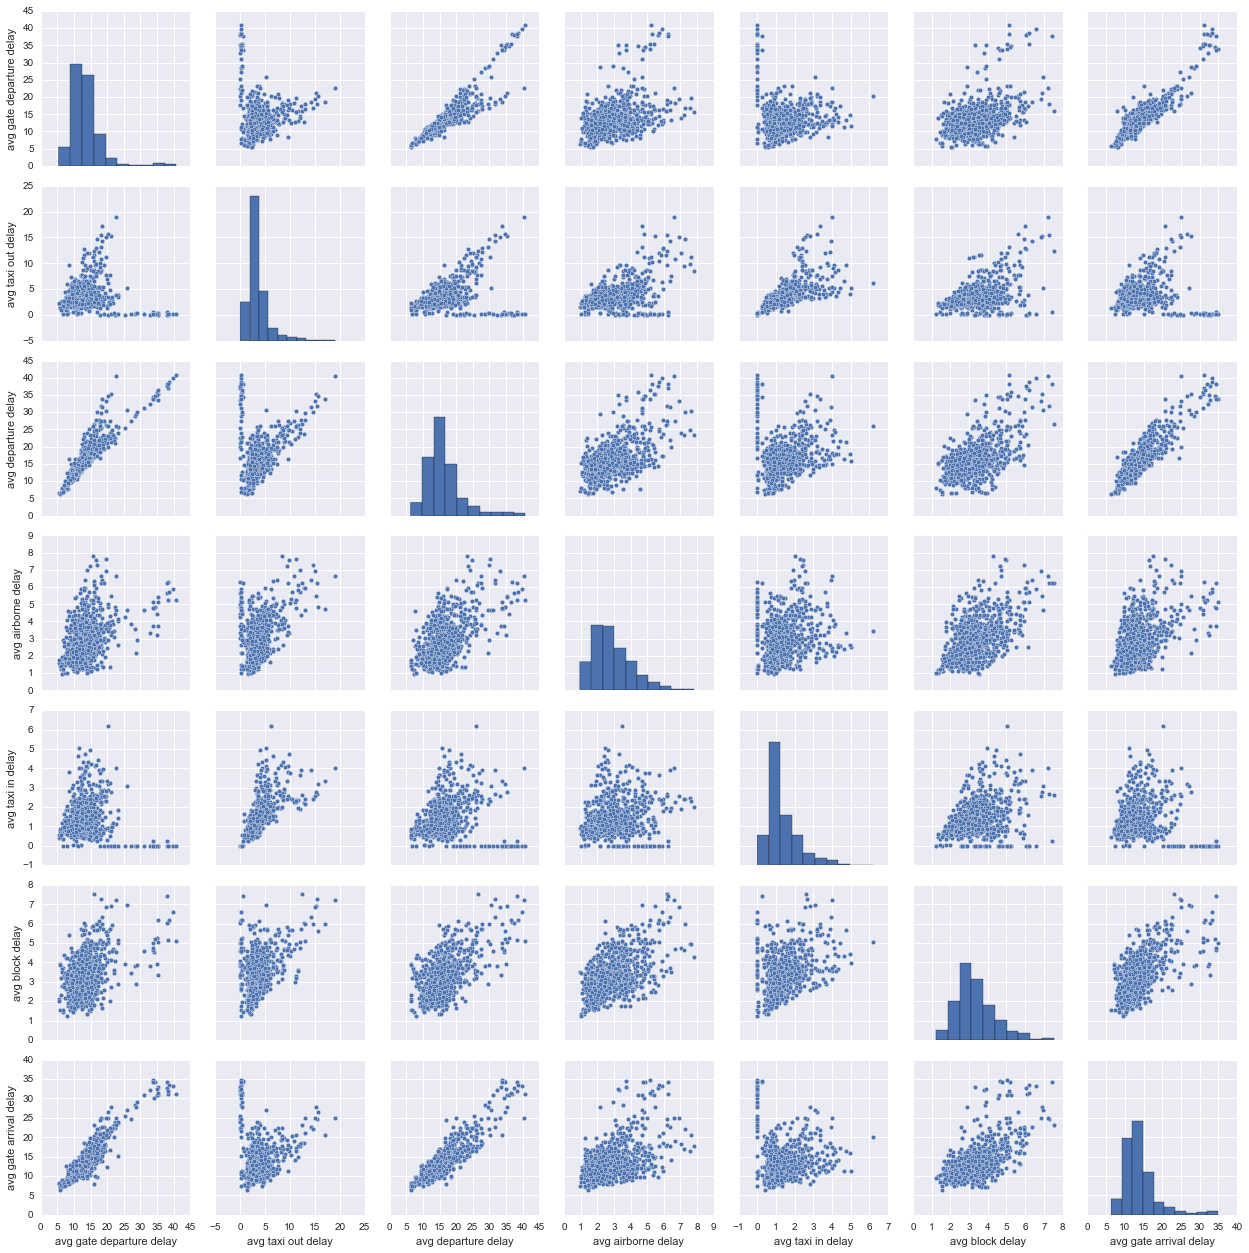

In [24]:
sns.pairplot(delays)

### Step 3: Principal Component Analysis

#### Delays

In [25]:
ss = StandardScaler()
scaled_delays = ss.fit_transform(delays)

In [26]:
pca = PCA(n_components=2)
X_r = pca.fit(scaled_delays).transform(scaled_delays)

print('explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [ 0.55125557  0.25952781]


In [27]:
pd.DataFrame(zip(delays.columns, pca.components_[0]), 
             columns=['Columns', 'Importance'])\
                .sort_values('Importance', ascending=False)

,Columns,Importance
2,avg departure delay,0.483154
6,avg gate arrival delay,0.440044
0,avg gate departure delay,0.411762
5,avg block delay,0.406831
3,avg airborne delay,0.369699
1,avg taxi out delay,0.266244
4,avg taxi in delay,0.174071


I'm using Principal Component Analysis on my `delays` dataframe for exploratory data analysis and found the importance of each type of delay. It shows that the most important delay is:
1. average departure delay
2. average gate arrival delay
3. average gate departure delay
4. average block delay
5. average airborne delay
6. average taxi out delay
7. average taxi in delay

#### PCA for Clustering

In [28]:
X = cleaned_df.drop('LocID', axis=1)
scaled_cleaned_df = ss.fit_transform(X)

In [29]:
pca = PCA(n_components=5)
X_r = pca.fit(scaled_cleaned_df).transform(scaled_cleaned_df)

explained_variance = pca.explained_variance_ratio_

print('explained variance ratio (first two components): %s' % str(explained_variance))

explained variance ratio (first two components): [ 0.4379673   0.18160047  0.12044012  0.08720921  0.06338317]


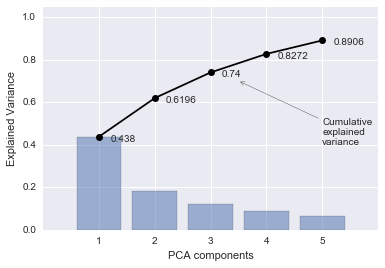

In [30]:
# Cumulative Explained Variance
x = np.arange(1,6)
plt.plot(x, np.cumsum(explained_variance), '-o', color='black')
plt.bar(x, explained_variance, align='center', alpha=0.5)

plt.ylim(0, 1.05)
plt.annotate('Cumulative\nexplained\nvariance',
             xy=(3.5, .7), arrowprops=dict(arrowstyle='->'), xytext=(5, .4))

for i,j in zip(x, np.cumsum(explained_variance)):
    plt.annotate(str(j.round(4)),xy=(i+.2,j-.02))

plt.xticks(range(1,6))
plt.xlabel('PCA components')
plt.ylabel('Explained Variance')
plt.show()

best silhouette score: 0.313090471132


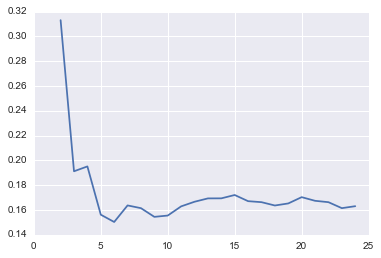

In [31]:
# this plot measures the silhouette scores of 1 cluster to 25 clusters 
# and finds the best silhouette score, which in turn finds the best cluster
find_best_cluster(scaled_cleaned_df,2,25)

I will be using KMeans Clustering on 4 clusters

### Step 4: KMeans Clustering

In [32]:
# This KMeans clustering module returns labels, centroids, and inertia
kmeans = kmeans(scaled_cleaned_df, 4)

In [33]:
cleaned_df['labels'] = kmeans['labels']

In [34]:
cleaned_df.columns

Index([u'LocID', u'percentage of departure cancellations',
       u'percentage of arrival cancellations',
       u'percentage of departure diversions',
       u'percentage of arrival diversions', u'year',
       u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'avg gate departure delay', u'avg taxi out time',
       u'avg taxi out delay', u'avg departure delay', u'avg airborne delay',
       u'avg taxi in delay', u'avg block delay', u'avg gate arrival delay',
       u'labels'],
      dtype='object')

In [35]:
airports.columns

Index([u'key', u'LocID', u'airport name', u'facility type', u'FAA region',
       u'county', u'city', u'state', u'airport type', u'latitude',
       u'longiutde', u'Boundary Data Available'],
      dtype='object')

In [36]:
df = pd.merge(airports, cleaned_df, how='inner', on='LocID')

#### Exploratory Data Analysis on Cluster

In [37]:
mask = (df['labels'] == 0)
df[mask].head()

,key,LocID,airport name,facility type,FAA region,county,city,state,airport type,latitude,...,percent on-time gate arrivals,avg gate departure delay,avg taxi out time,avg taxi out delay,avg departure delay,avg airborne delay,avg taxi in delay,avg block delay,avg gate arrival delay,labels
1,2885.0,SJU,LUIS MUNOZ MARIN INTL,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,...,0.7604,12.74,14.14,3.03,14.43,1.63,1.36,4.04,14.65,0
3,2885.0,SJU,LUIS MUNOZ MARIN INTL,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,...,0.7414,12.53,15.22,3.16,14.97,1.55,1.71,4.09,16.31,0
12,2885.0,SJU,LUIS MUNOZ MARIN INTL,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,...,0.7604,12.74,14.14,3.03,14.43,1.63,1.36,4.04,14.65,0
14,2885.0,SJU,LUIS MUNOZ MARIN INTL,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,...,0.7414,12.53,15.22,3.16,14.97,1.55,1.71,4.09,16.31,0
23,2885.0,SJU,LUIS MUNOZ MARIN INTL,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,...,0.7604,12.74,14.14,3.03,14.43,1.63,1.36,4.04,14.65,0


In [38]:
df[mask].describe()

,key,latitude,longiutde,percentage of departure cancellations,percentage of arrival cancellations,percentage of departure diversions,percentage of arrival diversions,year,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,avg gate departure delay,avg taxi out time,avg taxi out delay,avg departure delay,avg airborne delay,avg taxi in delay,avg block delay,avg gate arrival delay,labels
count,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.0
mean,1841.420804,36.463461,-87.612559,0.514421,0.485579,0.564653,0.435347,2009.275020,0.738718,0.695434,0.731588,15.251742,13.189949,3.178148,17.671797,2.802695,1.222183,3.483522,15.400512,0.0
std,979.966271,6.610318,15.072060,0.024531,0.024531,0.123850,0.123850,3.355793,0.037970,0.040190,0.036342,1.812496,2.267476,1.076075,2.019646,0.919502,0.539281,0.900623,2.180593,0.0
min,246.000000,18.439295,-149.998194,0.406593,0.285714,0.000000,0.000000,2004.000000,0.577100,0.549700,0.614100,11.670000,7.960000,0.650000,13.940000,1.130000,0.230000,1.610000,7.840000,0.0
25%,836.000000,32.116083,-94.713906,0.500876,0.471679,0.489760,0.357326,2007.000000,0.715500,0.670800,0.712700,13.870000,11.940000,2.410000,16.050000,2.170000,0.860000,2.810000,13.960000,0.0
50%,1895.000000,38.174086,-84.219410,0.513961,0.486039,0.573290,0.426710,2008.000000,0.744700,0.700450,0.736100,14.940000,12.810000,3.030000,17.440000,2.620000,1.100000,3.390000,15.030000,0.0
75%,2527.000000,41.504111,-78.730583,0.528321,0.499124,0.642674,0.510240,2013.000000,0.769100,0.727600,0.755700,16.370000,14.350000,3.690000,19.187500,3.280000,1.490000,3.980000,16.630000,0.0
max,3575.000000,61.174083,-66.002004,0.714286,0.593407,1.000000,1.000000,2014.000000,0.801400,0.776000,0.860300,21.450000,19.300000,7.170000,23.490000,5.500000,3.980000,6.140000,22.620000,0.0


#### Feature Importance for Cluster

In [39]:
X_mask = df[mask].drop(['key', 'LocID', 'airport name', 'facility type',
                        'FAA region', 'county', 'city', 'state', 'airport type',
                        'Boundary Data Available'], axis=1)

feature_importance(X_mask)

,Features,Importance,Average
13,avg departure delay,0.460146,17.671797
10,avg gate departure delay,0.395945,15.251742
17,avg gate arrival delay,0.275012,15.400512
11,avg taxi out time,0.219035,13.189949
3,percentage of arrival cancellations,0.207769,0.485579
16,avg block delay,0.205870,3.483522
12,avg taxi out delay,0.197082,3.178148
15,avg taxi in delay,0.194385,1.222183
14,avg airborne delay,0.139967,2.802695
0,latitude,0.064074,36.463461
